<a href="https://colab.research.google.com/github/melinadwisafitri/tourism-recomendatrion/blob/main/bismillah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sistem Rekomendasi mencari lokasi wisata di Indonesia

Sistem digunakan untuk meberikan rekomendasi nama destinasi lokasi wisata berdasarkan cotent bases filtering (yang digunakan adalah nama lokasi yang di filter berdasarkan kesamaan lokasi/kota)

## Data Source
Data diambil dari kaggle, terdapat 4 file di dalam file zip

[Source data Indonesia Tourism Destination](https://www.kaggle.com/aprabowo/indonesia-tourism-destination)

jadi nanti

Import semua Library yang akan digunakan, import dilakukan pada proses awal karena untuk mempermudah proses pengerjaan.

In [ ]:
!pip install kaggle

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from google.colab import files
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

Karena Data diambil dari kaggle, untuk mempermudah proses load data bisa menggunakan library kaggle.

Install kaggle, lalu upload file key token yang telah di *generate*  dari account yang dimiliki. Lalu membuat direktory baru bernama kaggle, pindah data kaggle.json yang sudah kita upload, arahkan ke folder kaggle yang sudah dibuat sebelumnya, lalu atur *permission access* supaya owner/user, grup, other bisa untuk *read, write and execution* terhadap data kaggle.json dengan menggunakan ```chmood 600```

In [ ]:
upload = files.upload()
for k in upload.keys():
  print(k)

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


## Data Loading

Download dataset Indonesia torism destination dengan menggunakan API kaggle file akan disimpan dalam ```/content/```

In [ ]:
!kaggle datasets download -d aprabowo/indonesia-tourism-destination

  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 1.43MB/s]


### Unzip File zip

Setelah data di download, ternyata data berbentuk file zip, yang didalamnya terdapat 4 file csv yaitu:
1. tourism_ with_id.csv : file ini berisi informasi lokasi wisata dari 5 kota di Indonesia 
2. user.csv : file ini berisi mengenai data pengguna (data dummy)
3. tourism_rating.csv : file ini berisi mengenai data rating dari bebrapa tempat lokasi wissata yang diberikan oleh user 
4. package_tourism.csv : file ini berisi package lokasi wisata

Buat satu directory yang berfungsi untuk menampung data dari indonesia-tourism-destination.zip dengan menggunakan 

```!mkdir name_directory```

untuk ektract data zip bisa menggunakan script 



```
!unzip -q indonesia-tourism-destination.zip
```
kenapa terdapat -q didalam script ```!unzip``` dikarenakan untuk menyembunyikan comment yang muncul


In [ ]:
!mkdir -p /content/destination_tourism
!unzip -q indonesia-tourism-destination.zip -d /content/destination_tourism

### Load Data
Load data masing-masing file kedalam variable yang mengambarkan nama dari file tersebut, data di load dengan menggunakan library **Pandas**

Kemudian cek berapa jumlah masing-masing data dalam varible tersebut dengan menggunkan fungsi ```len()```

In [ ]:
package_tourism = pd.read_csv('/content/destination_tourism/package_tourism.csv')
tourism_rating = pd.read_csv('/content/destination_tourism/tourism_rating.csv')
tourism_user = pd.read_csv('/content/destination_tourism/user.csv')
tourism_info = pd.read_csv('/content/destination_tourism/tourism_with_id.csv')

print(f'Jumlah data package tourism : {len(package_tourism)}')
print(f'Jumlah data tourism rating: {len(tourism_rating)}')
print(f'Jumlah user: {len(tourism_user)}')
print(f'jumlah information tourism: {len(tourism_info)}')

Jumlah data package tourism : 100
Jumlah data tourism rating: 10000
Jumlah user: 300
jumlah information tourism: 437


Setelah data csv di baca dan di letakkan pada variable diketahui bahwa data package tourism berjumlah 100 data rating berjumlah 10.000 jumlah user 300 dan jumlah tempat wisata 437

## Exploratory Data Unvariate

Setelah setiap file csv di deklarasikan ke dalam sebuah variable maka data per variable akan di analisis untuk mengetahui apa jenis data yang ada.

### Explorasi package tourism


In [ ]:
package_tourism

,Package,City,Place_Tourism1,Place_Tourism2,Place_Tourism3,Place_Tourism4,Place_Tourism5
0,1,Jakarta,Pasar Tanah Abang,Taman Ayodya,Museum Tekstil,NaN,NaN
1,2,Jakarta,Pasar Tanah Abang,Pasar Taman Puring,Pasar Petak Sembilan,NaN,NaN
2,3,Jakarta,Perpustakaan Nasional,Monas,Masjid Istiqlal,NaN,NaN
3,4,Jakarta,Pulau Tidung,Pulau Bidadari,Pulau Pari,Pulau Pramuka,Pulau Pelangi
4,5,Jakarta,Museum Satria Mandala,Museum Wayang,Museum Bahari Jakarta,Museum Macan (Modern and Contemporary Art in N...,NaN
...,...,...,...,...,...,...,...
95,96,Surabaya,Ekowisata Mangrove Wonorejo,Taman Harmoni Keputih,Taman Kunang-Kunang,Taman Ekspresi Dan Perpustakaan,Museum De Javasche Bank
96,97,Surabaya,Ciputra Waterpark,Kenjeran Park,Kebun Binatang Surabaya,Food Junction Grand Pakuwon,| Atlantis Land Surabaya
97,98,Surabaya,Museum Kesehatan Dr. Adhyatma,Patung Buddha Empat Rupa,Taman Hiburan Rakyat,Taman Bungkul,Taman Flora Bratang Surabaya
98,99,Surabaya,Taman Ekspresi Dan Perpustakaan,Museum De Javasche Bank,Surabaya Museum (Gedung Siola),Museum Mpu Tantular,Taman Air Mancur Menari Kenjeran


In [ ]:
package_tourism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Package         100 non-null    int64 
 1   City            100 non-null    object
 2   Place_Tourism1  100 non-null    object
 3   Place_Tourism2  100 non-null    object
 4   Place_Tourism3  100 non-null    object
 5   Place_Tourism4  66 non-null     object
 6   Place_Tourism5  39 non-null     object
dtypes: int64(1), object(6)
memory usage: 5.6+ KB


Data package tourism berisi 7 kolom dengan 100 baris, variable kolom (Package, city, place_tourism1, place_tourism2, place_tourism3, place_tourism4) dengan package memiliki type data integer sedangan untuk 5 variable kolom lainnya bertype string/object

### Ekplorasi data *Tourism Ratings*

In [ ]:
tourism_rating

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


In [ ]:
tourism_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


Pada data rating memiliki 3 kolom (User Id, place Id, place Ratting) dengan type data integer
* user id = untuk id user
* place id = untuk id dari tempat/lokasi wisata
* Place rating = untuk rating setiap lokasi yang diberikan user

lalu untuk mengetahui berapa nilai dari min-max rating maka diperlukan deskripsi statistika digunakan fungsi ```data.describe()```

In [ ]:
tourism_rating.describe().T

,count,mean,std,min,25%,50%,75%,max
User_Id,10000.0,151.2927,86.137374,1.0,77.00,151.0,226.0,300.0
Place_Id,10000.0,219.4164,126.228335,1.0,108.75,220.0,329.0,437.0
Place_Ratings,10000.0,3.0665,1.379952,1.0,2.00,3.0,4.0,5.0


Diketahui nilai minimum rating adalah 1.0 dan maximum rating adalah 5.0 dengan jumlah data 10000




In [ ]:
tourism_rating.corr()

,User_Id,Place_Id,Place_Ratings
User_Id,1.000000,0.00023,-0.070832
Place_Id,0.000230,1.00000,0.003190
Place_Ratings,-0.070832,0.00319,1.000000


Plot data dengan rating sebagai x dan Place Id sebagai y

<function matplotlib.pyplot.show>

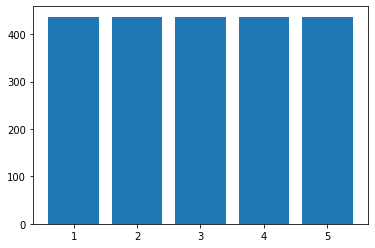

In [ ]:
plt.bar(tourism_rating['Place_Ratings'], tourism_rating['Place_Id'])
plt.show

### Eksplorasi data User

In [ ]:
tourism_user

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20
...,...,...,...
295,296,"Lampung, Sumatera Selatan",31
296,297,"Palembang, Sumatera Selatan",39
297,298,"Bogor, Jawa Barat",38
298,299,"Sragen, Jawa Tengah",27


In [ ]:
tourism_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


Diketahui data user berjumlah 300 dengan nama kolom user_id, location(asal user) dan age
Data akan ditampilkan dalam visualisasi, data akan di petakan berdasarkan user_Id dan asal provinsi dari user.

Dikarenakan data lokasi belum terpisah antara nama kota dan provinsi maka data lokasi akan dipecah menjadi kota dan provinsi.

In [ ]:
tourism_user[['kota', 'provinsi']] = tourism_user['Location'].str.split(',', expand=True)
tourism_user

,User_Id,Location,Age,kota,provinsi
0,1,"Semarang, Jawa Tengah",20,Semarang,Jawa Tengah
1,2,"Bekasi, Jawa Barat",21,Bekasi,Jawa Barat
2,3,"Cirebon, Jawa Barat",23,Cirebon,Jawa Barat
3,4,"Bekasi, Jawa Barat",21,Bekasi,Jawa Barat
4,5,"Lampung, Sumatera Selatan",20,Lampung,Sumatera Selatan
...,...,...,...,...,...
295,296,"Lampung, Sumatera Selatan",31,Lampung,Sumatera Selatan
296,297,"Palembang, Sumatera Selatan",39,Palembang,Sumatera Selatan
297,298,"Bogor, Jawa Barat",38,Bogor,Jawa Barat
298,299,"Sragen, Jawa Tengah",27,Sragen,Jawa Tengah


Setelah data dipecah data akan divisualisasikan dengan menggunakan barplot User_Id sebagai height

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


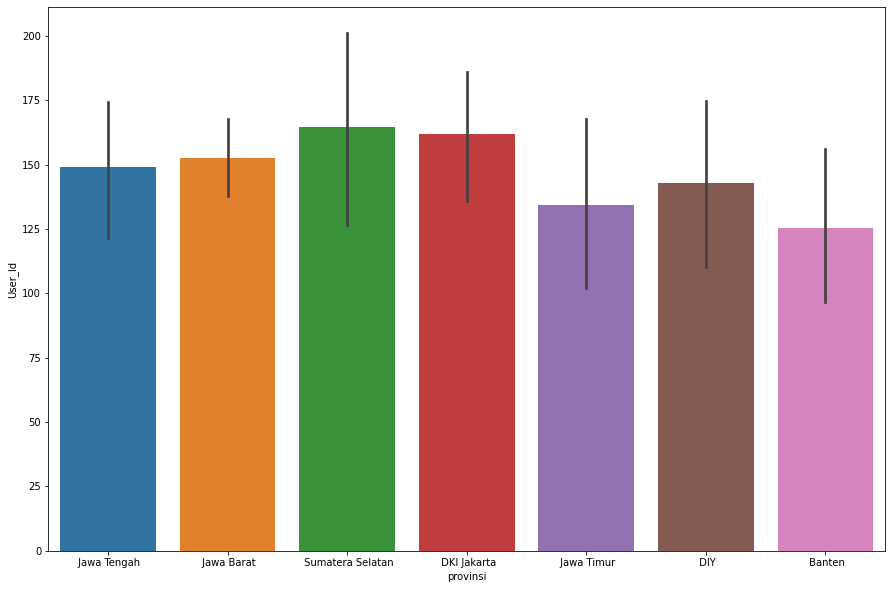

In [ ]:
plt.figure(figsize=(15, 10))
sns.barplot(tourism_user['provinsi'], tourism_user['User_Id'])
plt.show()

### Eksplorasi data Tourism information

In [ ]:
tourism_info

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000,4.4,45.0,"{'lat': -7.4338593, 'lng': 112.7199058}",-7.433859,112.719906,NaN,433
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.291346799999999, 'lng': 112.7398218}",-7.291347,112.739822,NaN,434
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0,4.4,45.0,"{'lat': -7.2752955, 'lng': 112.7549381}",-7.275296,112.754938,NaN,435
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.294330299999999, 'lng': 112.7617534}",-7.294330,112.761753,NaN,436


In [ ]:
tourism_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


Di dalam file tourism_info terdapat 13 kolom tetapi, ada 2 kolom dengan nama yang tidak jelas/tidak bisa dipahami maka kolom tersebut akan dihapus.

In [ ]:
tourism_inform = tourism_info.loc[:, ~tourism_info.columns.str.contains('^Unnamed')]
tourism_inform

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134
...,...,...,...,...,...,...,...,...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000,4.4,45.0,"{'lat': -7.4338593, 'lng': 112.7199058}",-7.433859,112.719906
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.291346799999999, 'lng': 112.7398218}",-7.291347,112.739822
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0,4.4,45.0,"{'lat': -7.2752955, 'lng': 112.7549381}",-7.275296,112.754938
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.294330299999999, 'lng': 112.7617534}",-7.294330,112.761753


Diketahui bahwa :
- Place-Id : id untuk tempat wisata
- Place_Name: Nama dari lokasi wisata
- Description: penjelasan singkat mengenai tempat wisata tersebut
- Category: wisata termasuk dalam kategori apa(budaya, taman-hiburan dll)
- City: Lokasi tempat wisata(kota)
- Price: biaya masuk ke lokasi wisata 
- Rating : tingkat kepuasan pelanggan
- Time_Minutes: waktu perjalanan
- Coordinate: koordinat dari lokasi wisata
- Lat: Garis Lintang
- Long: Garis Bujur

Variable tourism_info memiliki 437 data, karena di dalam minut terdapat nan/missing value, makan missing value tersebut diganti dengan nilai rata-rata dari data pada column tersebut.


In [ ]:
tourism_inform.isna().sum()

Place_Id          0
Place_Name        0
Description       0
Category          0
City              0
Price             0
Rating            0
Time_Minutes    232
Coordinate        0
Lat               0
Long              0
dtype: int64

Data time minutes memiliki banyak missing value, kalau data row yang mengandung missing value dihapus maka akan berakibat berkurangnya data hampir 50% sehingga untuk mengatasi itu, dipilih untuk drop data time_minus dari dataFrame, untuk mencegah kehilangan data yang banyak.


In [ ]:
tourism_inform = tourism_inform.drop(columns=["Time_Minutes"])
tourism_inform

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134
...,...,...,...,...,...,...,...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000,4.4,"{'lat': -7.4338593, 'lng': 112.7199058}",-7.433859,112.719906
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0,4.6,"{'lat': -7.291346799999999, 'lng': 112.7398218}",-7.291347,112.739822
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0,4.4,"{'lat': -7.2752955, 'lng': 112.7549381}",-7.275296,112.754938
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0,4.6,"{'lat': -7.294330299999999, 'lng': 112.7617534}",-7.294330,112.761753


## Content Based Filtering

Teknik yang digunakan untuk memberikan rekomendasi kepada user berdasarkan history pencarian yang mirip.

### Data Preparation

Menyiapkan data yang akan digunakan untuk membuat sistem rekomendasi berdasarkan history item.

Data yang digunakan adalah data tourism_with_id/tourism_inform data yang berisi mengenai penjelasan lokasi wisata, data berjumlah 437. Data yang digunaka akan diambil dan disimpan kedalam sebuah dataFrame baru, data yang akan diambil adalah place_id, place_name dan place_city.

In [ ]:
data_preparation = tourism_inform

id_place = data_preparation['Place_Id'].tolist()
city = data_preparation['City'].tolist()
name_place = data_preparation['Place_Name'].tolist()
#category_place = data_preparation['Category']
data_content = pd.DataFrame({
    'place_id' :id_place,
    'place_city' : city,
    'place_name': name_place,
    #'place_category': category_place,
})
data_content

,place_id,place_city,place_name
0,1,Jakarta,Monumen Nasional
1,2,Jakarta,Kota Tua
2,3,Jakarta,Dunia Fantasi
3,4,Jakarta,Taman Mini Indonesia Indah (TMII)
4,5,Jakarta,Atlantis Water Adventure
...,...,...,...
432,433,Surabaya,Museum Mpu Tantular
433,434,Surabaya,Taman Bungkul
434,435,Surabaya,Taman Air Mancur Menari Kenjeran
435,436,Surabaya,Taman Flora Bratang Surabaya


In [ ]:
data_content.isna().values.any()

False

### TFIDF (Matrix)

Untuk melakukan Content Filtering disini menggunakan TfidVectorizer yang berfungsi untuk konvert/merubah raw document menjadi matrix.

Data yang akan dirubah menjadi matrix adalah data City/nama Kota

In [ ]:
vector = TfidfVectorizer()

In [ ]:
vector.fit(data_content['place_city'])
vector.get_feature_names()

['bandung', 'jakarta', 'semarang', 'surabaya', 'yogyakarta']

Data City memiliki 5 lokasi/kota yaitu :
* bandung
* Surabaya
* Jakarta 
* yogyakarta
* Semarang

`fit` digunakan untuk mempelajari kosakata dari data yang akan digunakan

`fit_transform` digunakan untuk mempelajari kosakata dan diubah menjadi IDF yang memberikan nilai berupa matrix


In [ ]:
matrix = vector.fit_transform(data_content['place_city'])
matrix.shape

(437, 5)

Data hasil konversi disimpan dalam variable matrix, data ini memiliki ukuran (437, 5), nilai 5 diambil dari 5 kota(feature yang berada pada place_city)

Data lalu akan dirubah menjadi satu dataFrame, didalam dataframe tersebut data hasil matrix akan dirubah menjadi vektor dengan menggunakan `.todense()` 

Data akan diambil 5 sample untuk sumbu x dan sumbu y

In [ ]:
pd.DataFrame(
    matrix.todense(),
    columns = vector.get_feature_names(),
    index = data_content.place_name,
).sample(5, axis=0).sample(5, axis=1)

,bandung,semarang,jakarta,surabaya,yogyakarta
place_name,,,,,
Museum Mandala Wangsit Siliwangi,1.0,0.0,0.0,0.0,0.0
Gembira Loka Zoo,0.0,0.0,0.0,0.0,1.0
Masjid Salman ITB,1.0,0.0,0.0,0.0,0.0
Candi Donotirto,0.0,0.0,0.0,0.0,1.0
Museum Perangko,0.0,0.0,1.0,0.0,0.0


Diketahui bahwa seiap tempat akan berkorelasi dengan city/kota yang ditandai dengan nilai 1.0

Contoh Goa Gong memiliki nilai 1.0 pada kota Semarang, jadi Goa Gong terletak di semarang

### Cosine Similarity
Berfungsi untuk mengitung kesamaan data antar nama lokasi wisata.
Library yang digunakan adalah cosine_similarity



\begin{align}
  K(X, Y) = \frac{<X, Y>}{(||X|| * ||Y||}
\end{align}


In [ ]:
similarity = cosine_similarity(matrix, matrix)

In [ ]:
similarity

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

Data hasil perhitungan kesaamaan atar fitur akan disimpan dalam variable dataframe. 

In [ ]:
similarity_to_df = pd.DataFrame(
    similarity,
    columns = data_content.place_name,
    index = data_content.place_name,
)
print(f'Ukuran dari similarity : {similarity_to_df.shape}')
similarity_to_df.sample(5, axis=0).sample(5, axis=1)

Ukuran dari similarity : (437, 437)


place_name,Taman Flora Bratang Surabaya,Ciwangun Indah Camp Official,Pasar Seni,Panama Park 825,Taman Jomblo
place_name,,,,,
Taman Cattleya,0.0,0.0,1.0,0.0,0.0
Lawang Sewu,0.0,0.0,0.0,0.0,0.0
Rumah Sipitung,0.0,0.0,1.0,0.0,0.0
Pantai Drini,0.0,0.0,0.0,0.0,0.0
Wisata Lereng Kelir,0.0,0.0,0.0,0.0,0.0


Berdasarkan data diatas dikatahui bahwa Taman Cattleyamemiliki kesamaan dengan Pasar Seni data diatas iambil sample 5 saja

### Modeling

Membuat sistem rekomendasi berdasarkan kesamaan data yang diambil dari kesamaan kotanya

In [ ]:
def recomended_city_tourism(place_name,
                            similarity_name=(similarity_to_df),
                            items=data_content[['place_name', 'place_city']], 
                            n=10):
  i = similarity_name.loc[place_name].to_numpy().argpartition(
      range(-1, -n, -1)
  )
  h_index = similarity_name.columns[i[-1:-(n+2):-1]]
  h_index = h_index.drop(place_name, errors='ignore')
  return pd.DataFrame(h_index).merge(items).head(n)

Karena ingin meminta rekomendasi berdasarkan tempat Pulau Pramuka maka ditampilkan terlebih dahulu kriteria dari Pantai Ancol

In [ ]:
data_content[data_content.place_name.eq('Pantai Ancol')]

,place_id,place_city,place_name
55,56,Jakarta,Pantai Ancol


Melakukan rekomendasi berdasarkan Pantai Ancol menggunakan model yang telah di susun berdasarkan kesamaan lokasi/nama kota

In [ ]:
recomended = recomended_city_tourism('Pantai Ancol')
recomended

,place_name,place_city
0,Monumen Nasional,Jakarta
1,Taman Lapangan Banteng,Jakarta
2,Taman Ayodya,Jakarta
3,Museum Kebangkitan Nasional,Jakarta
4,Tugu Proklamasi,Jakarta
5,Taman Legenda Keong Emas,Jakarta
6,Museum Tekstil,Jakarta
7,Museum Sumpah Pemuda,Jakarta
8,Taman Agrowisata Cilangkap,Jakarta
9,Jakarta Aquarium dan Safari,Jakarta


Karena data yang diseting untuk ditampilkan di dalam model adalah 10 data yang ditampilkan juga berjumlah 10 data tersebut memililki nama kota/lokasi yang sama yaitu Jakarta

### Evaluasi Model

\begin{align}
  precission = \frac{recomendation relevant}{sum item recommended}
  \end{align}

Diketahui bahwa sistem merekomendasikan 10 tempat yang memiliki nilai berdasarkan kota yang sama, dari 10 item tersebut memiliki nilai kota yang sama yaitu jakarta

In [ ]:
precision = (len(recomended['place_city'] == 'Jakarta')/len(recomended))*100
print(f'precission: {precision} %')

precission: 100.0 %


Diketahui bahwa pecission dari data yang direkomendasikan adalah 100%, sehingga mengindikasikan sistem dapat berjalan dengan baik dikarenakan yang digunakan untuk matrix nya adalah nama kota (hanya ada 5 kategori kota)

## Colaborative Filtering

Tenik ini digunakan untuk merekomendasikan user berdasarkan user_group atau bebeberapa user lain. Data yang digunakan adalah data rating dan data_inform yang sudah diberikan oleh pengguna/user.

### Data Understanding

Untuk membuat colaborative Filtering data yang digunakan adalah data rating

In [ ]:
rate = tourism_rating
rate

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


### Data Preparation

Menggabungkan data rating dengan data informasi tempat bertujuan untuk mengetahui secara detail dari informasi berdasarkan rating yang diberikan user.
Data yang akan digunakan untuk Colaborative FIltering yaitu data yang berada di file rating sebelumnya dan data tempat serta rating tempat secara keseluruhan yang diambil dari data_information.

In [ ]:
data_colaborative = pd.merge(rate, tourism_inform[[
                                                  'Place_Id',
                                                  'Place_Name', 
                                                  'City',
                                                  'Category',
                                                  'Rating'
]])
data_colaborative

,User_Id,Place_Id,Place_Ratings,Place_Name,City,Category,Rating
0,1,179,3,Candi Ratu Boko,Yogyakarta,Budaya,4.6
1,22,179,4,Candi Ratu Boko,Yogyakarta,Budaya,4.6
2,40,179,3,Candi Ratu Boko,Yogyakarta,Budaya,4.6
3,49,179,5,Candi Ratu Boko,Yogyakarta,Budaya,4.6
4,74,179,3,Candi Ratu Boko,Yogyakarta,Budaya,4.6
...,...,...,...,...,...,...,...
9995,240,140,3,Bendung Lepen,Yogyakarta,Taman Hiburan,4.6
9996,247,140,4,Bendung Lepen,Yogyakarta,Taman Hiburan,4.6
9997,261,140,4,Bendung Lepen,Yogyakarta,Taman Hiburan,4.6
9998,267,140,3,Bendung Lepen,Yogyakarta,Taman Hiburan,4.6


Data berjumlah 1000 baris, lalu cek data apakah data memiliki missing value atau tidak

In [ ]:
data_colaborative.isna().values.any()

False

Data tidak ada yang mengalami missing values.

Kemudian untuk mempermudah, dilakukan inisialisasi variable baru terhadap data yang sudah diambil terlebih dahulu. Dan data diurutkan berdasarkan Id tempat

In [ ]:
data_preparation_fix = data_colaborative.sort_values('Place_Id')
data_preparation_fix

,User_Id,Place_Id,Place_Ratings,Place_Name,City,Category,Rating
9275,36,1,4,Monumen Nasional,Jakarta,Budaya,4.6
9292,265,1,4,Monumen Nasional,Jakarta,Budaya,4.6
9291,254,1,5,Monumen Nasional,Jakarta,Budaya,4.6
9290,235,1,4,Monumen Nasional,Jakarta,Budaya,4.6
9289,227,1,5,Monumen Nasional,Jakarta,Budaya,4.6
...,...,...,...,...,...,...,...
1078,234,437,3,Gereja Perawan Maria Tak Berdosa Surabaya,Surabaya,Tempat Ibadah,4.8
1077,222,437,2,Gereja Perawan Maria Tak Berdosa Surabaya,Surabaya,Tempat Ibadah,4.8
1076,217,437,1,Gereja Perawan Maria Tak Berdosa Surabaya,Surabaya,Tempat Ibadah,4.8
1083,270,437,1,Gereja Perawan Maria Tak Berdosa Surabaya,Surabaya,Tempat Ibadah,4.8


Data yang akan digunakan yaitu data user_id dan data place_id data tersebut diambil yang unique kemudian diajadikan list. 

Selanjutnya dilakukan encode data id_place dan id_user, berfungsi untuk melakukan indexing/membuat data menjadi integer.

Data user dan place dirubah menjadi list untuk selanjutnya dilakukan encode data tersebut.

In [ ]:
id_user = data_preparation_fix['User_Id'].unique().tolist()
id_place = data_preparation_fix['Place_Id'].unique().tolist()


user_encode = {user: u for u, user in (enumerate(id_user))}
#encode angka ke user
encode_user = {u: user for u, user in (enumerate(id_user))}


place_encode = {place: p for p, place in enumerate(id_place)}
#encioding dari angka ke place
encode_place = {p : place for p, place in enumerate(id_place)}

In [ ]:
print(user_encode)
print(encode_user)
print(place_encode)
print(encode_place)

{36: 0, 265: 1, 254: 2, 235: 3, 227: 4, 189: 5, 187: 6, 167: 7, 169: 8, 159: 9, 118: 10, 105: 11, 100: 12, 86: 13, 74: 14, 64: 15, 162: 16, 38: 17, 292: 18, 17: 19, 295: 20, 2: 21, 217: 22, 30: 23, 43: 24, 46: 25, 56: 26, 57: 27, 59: 28, 75: 29, 94: 30, 98: 31, 134: 32, 137: 33, 154: 34, 160: 35, 175: 36, 188: 37, 203: 38, 110: 39, 231: 40, 55: 41, 285: 42, 267: 43, 255: 44, 242: 45, 240: 46, 280: 47, 220: 48, 97: 49, 190: 50, 185: 51, 206: 52, 127: 53, 247: 54, 288: 55, 171: 56, 150: 57, 143: 58, 205: 59, 113: 60, 53: 61, 108: 62, 91: 63, 26: 64, 6: 65, 5: 66, 4: 67, 111: 68, 290: 69, 276: 70, 238: 71, 232: 72, 226: 73, 222: 74, 212: 75, 183: 76, 179: 77, 139: 78, 120: 79, 116: 80, 106: 81, 109: 82, 92: 83, 87: 84, 35: 85, 12: 86, 11: 87, 1: 88, 103: 89, 184: 90, 264: 91, 258: 92, 182: 93, 68: 94, 161: 95, 156: 96, 129: 97, 104: 98, 95: 99, 90: 100, 81: 101, 65: 102, 31: 103, 23: 104, 170: 105, 294: 106, 296: 107, 297: 108, 278: 109, 277: 110, 250: 111, 78: 112, 101: 113, 107: 114, 20

Data User_Id dan Place_Id yang telah di encode akan ditambahkan di dalam dataframe colaborative filtering_fix

In [ ]:
#memasukkan hasil encode ke dalam dataFrame
data_preparation_fix['id_user'] = data_preparation_fix['User_Id'].map(user_encode)
data_preparation_fix['id_place'] = data_preparation_fix['Place_Id'].map(place_encode)

In [ ]:
data_preparation_fix.head()

,User_Id,Place_Id,Place_Ratings,Place_Name,City,Category,Rating,id_user,id_place
9275,36,1,4,Monumen Nasional,Jakarta,Budaya,4.6,0,0
9292,265,1,4,Monumen Nasional,Jakarta,Budaya,4.6,1,0
9291,254,1,5,Monumen Nasional,Jakarta,Budaya,4.6,2,0
9290,235,1,4,Monumen Nasional,Jakarta,Budaya,4.6,3,0
9289,227,1,5,Monumen Nasional,Jakarta,Budaya,4.6,4,0


Data yang akan displit, sebelumnya diinisialisasi dahulu, dipecah kedalam masing-masing vaiable, jumlah data place dan user encode juga akan disimpan dalam varible sendiri-sendiri, jumlah data ini yang akan digunakan untuk menjalakan model.

In [ ]:
data = data_preparation_fix[['id_user', 'id_place']].values
rating_place_from_user =data_preparation_fix['Place_Ratings'].values

num_p = len(place_encode)
num_u = len(user_encode)
print(f'jumlah data user {num_u}\njumlah data tempat {num_p}')

jumlah data user 300
jumlah data tempat 437


### Split data Train and Val



MinMaxScaler data Ratings, Data rating di lakukan scalling menggunakan MinMaxScaler dari library sklearn, fungsi scaler ini untuk menormalisasi data, sehingga data bisa lebih optimal untuk digunakan.

In [ ]:
scall = MinMaxScaler(feature_range=(0, 1))

(10000,)


(10000, 1)

Dikarenakan data rating yang sudah diambil tidak bisa dingunakan kerena ukuran dari dari maka data akan reshape dulu dengan (-1, 1) yang memiliki arti menambah satu kolom. 

In [ ]:
rating_place_from_user_reshape = rating_place_from_user.reshape(-1, 1)
print(rating_place_from_user.shape)

(10000,)


In [ ]:

rating_place_from_user_scall = scall.fit_transform(rating_place_from_user_reshape)
rating_place_from_user_scall.shape

(10000, 1)

Data akan dipecah menjadi train 80% dan val 20%, split data memnfaatkan fitur train_test_split dari sklearn, untuk mempercepat process.

In [ ]:
train_user, val_user, train_rating, val_rating = train_test_split(
    data, rating_place_from_user_scall, test_size=0.2
)

print(f'jumlah dari data train {len(train_user)}')
print(f'Jumlah dari data validation {len(val_user)}')

jumlah dari data train 8000
Jumlah dari data validation 2000


### Training Model

Setelah data berhasil di periapkan dilanjutkan dengan membuat model baru dengan memanfaakan tensorflow berdasarkan proses embeding dari user_id dan place_id, dengan menggunakan perkalian dot product [0, 1] menggunakan sigmoid sebagai aktivasi

In [ ]:
class filtering_based_ratings(tf.keras.Model):
  def __init__(self, num_u, num_p, size_e, **place):
    super(filtering_based_ratings, self).__init__(**place)
    self.num_u = num_u
    self.num_p = num_p
    self.size_e = size_e
    self.user_e = Embedding(
        num_u,
        size_e,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf.keras.regularizers.l1(1e-6)
    )
    self.bias1 = Embedding(num_u, 1)
    self.place_e = Embedding(
        num_p,
        size_e,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf.keras.regularizers.l1(1e-6)
      )
    self.bias2 = Embedding(num_p, 1)

  def call(self, ins):
    u = self.user_e(ins[:, 0])
    bias1 = self.bias1(ins[:, 0])
    p = self.place_e(ins[:, 1])
    bias2 = self.bias2(ins[:, 1])

    user = tf.tensordot(u, p, 2)
    merge = user + bias1 + bias2

    return tf.nn.sigmoid(merge)

setelah model terbentuk data akan di training menggunkan optimizer ada dengan los binary_crossentropy berdasarakan metrics MAE(Mean Absolute Error)

In [ ]:
model = filtering_based_ratings(num_u, num_p, 16)
model.compile(optimizer = Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

Data di training dengan 10 epoch dan batch_size nya 5 

\begin{align}
  \frac{jumlah data train}{batchsize} = \frac{7000}{5} = 1400/perepochs
\end{align}

In [ ]:
h = model.fit(
    x=train_user, 
    y= train_rating, 
    batch_size=5,
    validation_data=(val_user, val_rating), 
    epochs=50, verbose=2)

Epoch 1/50
1600/1600 - 3s - loss: 0.6936 - mean_absolute_error: 0.2923 - val_loss: 0.6925 - val_mean_absolute_error: 0.2963
Epoch 2/50
1600/1600 - 2s - loss: 0.6869 - mean_absolute_error: 0.2896 - val_loss: 0.6925 - val_mean_absolute_error: 0.2977
Epoch 3/50
1600/1600 - 2s - loss: 0.6802 - mean_absolute_error: 0.2867 - val_loss: 0.6930 - val_mean_absolute_error: 0.2990
Epoch 4/50
1600/1600 - 2s - loss: 0.6746 - mean_absolute_error: 0.2840 - val_loss: 0.6942 - val_mean_absolute_error: 0.3004
Epoch 5/50
1600/1600 - 2s - loss: 0.6687 - mean_absolute_error: 0.2807 - val_loss: 0.6962 - val_mean_absolute_error: 0.3020
Epoch 6/50
1600/1600 - 2s - loss: 0.6662 - mean_absolute_error: 0.2786 - val_loss: 0.6972 - val_mean_absolute_error: 0.3022
Epoch 7/50
1600/1600 - 2s - loss: 0.6608 - mean_absolute_error: 0.2748 - val_loss: 0.6988 - val_mean_absolute_error: 0.3028
Epoch 8/50
1600/1600 - 2s - loss: 0.6563 - mean_absolute_error: 0.2718 - val_loss: 0.7015 - val_mean_absolute_error: 0.3040
Epoch 9/

Didapatkan nilai mae terendah adalah 0.2465 (25%) yang berarti nilai mae masih terlalu tinggi sehingga bisa berakibat data yang akan direkomendasikan kurang sesuai dengan nilai loss yang masih tinggi

#### Ploting Model

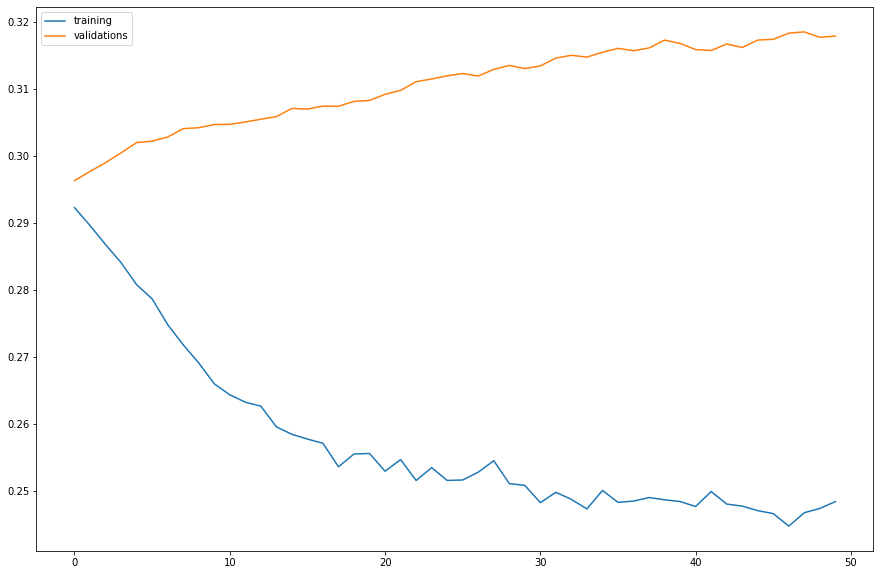

In [ ]:
train = h.history['mean_absolute_error']
val = h.history['val_mean_absolute_error']

e = range(len(train))

plt.figure(figsize=(15, 10))
plt.plot(e, train, label='training')
plt.plot(e, val, label="validations")
plt.legend()
plt.show()

### Evaluasi Model

Evaluasi dilakukan untuk mengetahui bagaimana tingkat error data sehingga bisa mengetau bagaimana performa dari data. Evaluasi menggunakan metrics MSE. 

\begin{align}
        \text{MAE } = (&\sum_{i=0}^n \mid y_i -y_i\mid) /n
    \end{align}

In [ ]:
ypred = model.predict(val_user)
mae = mean_absolute_error(val_rating, ypred)
print(mae)

0.3458515153229237


nilai mae yang di dapatkan tidak terlalu tinggi sehingga data ini cocok untuk digunakan dalam sistem rekomendasi, tetapi mae dengan nilai 34% terbilang cukup tinggi sehingga bisa mengakibatkan overfitting data

### System Rekomendation from user

data yang digunakan untuk proses ini diambil dari data yang sudah disimpan dalam directory pada proses data processing pada teknik content based learning



In [ ]:
place = tourism_inform

ratings = data_colaborative
place

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134
...,...,...,...,...,...,...,...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000,4.4,"{'lat': -7.4338593, 'lng': 112.7199058}",-7.433859,112.719906
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0,4.6,"{'lat': -7.291346799999999, 'lng': 112.7398218}",-7.291347,112.739822
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0,4.4,"{'lat': -7.2752955, 'lng': 112.7549381}",-7.275296,112.754938
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0,4.6,"{'lat': -7.294330299999999, 'lng': 112.7617534}",-7.294330,112.761753


Data akan diambil sampel 1 data yang digunakan diambil dari data nomer 2, lalu data tersebut nantinya id nya akan dibandingkan id user sehingga bisa meghasikan rekomendasi tempat wisata,

Data tersebut nantinya akan dibagi menjadi lokasi yang pernah dikunjungi dan lokasi yang tidak pernah dikunjungi sebelumnya.

In [ ]:
#user = input("Masukkan user id ")
user = ratings.User_Id.sample(2).iloc[0]
print(user)
place_visited = ratings[ratings.User_Id == user]

place_not = place[~place['Place_Id'].isin(place_visited.Place_Id.values)]['Place_Id']
place_not = list(
    set(place_not)
    .intersection(set(encode_place.keys()))
)
place_not = [[place_encode.get(a)] for a in place_not]
user_recomm = user_encode.get(user)
user_array = np.hstack(([[user_recomm]] * len(place_not), place_not))

225


In [ ]:
place_visited

,User_Id,Place_Id,Place_Ratings,Place_Name,City,Category,Rating
269,225,103,3,Tugu Pal Putih Jogja,Yogyakarta,Taman Hiburan,4.7
997,225,185,3,Pantai Krakal,Yogyakarta,Bahari,4.5
1317,225,166,3,Kebun Teh Nglinggo,Yogyakarta,Cagar Alam,4.5
2773,225,61,4,Tugu Proklamasi,Jakarta,Budaya,4.6
2986,225,381,1,Tugu Muda Semarang,Semarang,Budaya,4.7
3478,225,298,1,Gunung Lalakon,Bandung,Cagar Alam,4.8
3519,225,224,4,Dago Dreampark,Bandung,Taman Hiburan,4.2
3557,225,255,2,Museum Barli,Bandung,Budaya,4.4
3838,225,247,3,Kiara Artha Park,Bandung,Taman Hiburan,4.4
3839,225,247,3,Kiara Artha Park,Bandung,Taman Hiburan,4.4


Dilihat bahwa id yang diambil adalah 225 id tersebut melakukan penilaian ke beberapa tempat dengan nilai rating yang berbeda-beda

In [ ]:
predict = model.predict(user_array).flatten()

top_rate = predict.argsort()[-5:][::-1]
recomended_place = [
                    place_encode.get(place_not[a][0]) for a in top_rate
]

print(f' Rekomendasi dari user ber id : {user}')

print('---' * 10)
print("rekomendasi user dengan nilai rating tertinggi ")

top_place = (
    place_visited.sort_values(by='Place_Ratings', ascending=False)
).head(3).Place_Id.values

top_row = place[place['Place_Id'].isin(top_place)]
for r in top_row.itertuples():
  print(r.Place_Name, ':', r.Category)

print('----' * 10)
print("5 rekomendasi tertinggi")

recomended_top_rating = place[place['Place_Id'].isin(recomended_place)]
for r in recomended_top_rating.itertuples():
  print(r.Place_Name, ':', r.Category)

 Rekomendasi dari user ber id : 225
------------------------------
rekomendasi user dengan nilai rating tertinggi 
Kampung Wisata Taman Sari : Taman Hiburan
Pantai Watu Kodok : Bahari
Curug Cimahi : Cagar Alam
----------------------------------------
5 rekomendasi tertinggi
Museum Seni Rupa dan Kramik : Budaya
Museum Joang 45 : Budaya
Museum Basoeki Abdullah : Budaya
Wisata Mangrove Tapak : Cagar Alam
Old City 3D Trick Art Museum : Budaya


karena sistem rekomendasi yang sudah di setting dengan hanya menampilkan 5 data saja maka data rekomendasi hanya 5 data diambil berdasarkan rating tertinggi dari user terhadap tempat-tempat wisata tersebut